# Concrete strength Machine learning model

Importing the libraries

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

In [295]:
# Reading the data

df_raw = pd.read_csv('data/concrete_data.csv')
df = df_raw.copy(deep = True)
df.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [296]:
df.columns.to_list()

['Cement',
 'Blast Furnace Slag',
 'Fly Ash',
 'Water',
 'Superplasticizer',
 'Coarse Aggregate',
 'Fine Aggregate',
 'Age',
 'Strength']

In [297]:
print(df.info())
print('-'*40)
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Cement              1030 non-null   float64
 1   Blast Furnace Slag  1030 non-null   float64
 2   Fly Ash             1030 non-null   float64
 3   Water               1030 non-null   float64
 4   Superplasticizer    1030 non-null   float64
 5   Coarse Aggregate    1030 non-null   float64
 6   Fine Aggregate      1030 non-null   float64
 7   Age                 1030 non-null   int64  
 8   Strength            1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB
None
----------------------------------------
            Cement  Blast Furnace Slag      Fly Ash        Water  \
count  1030.000000         1030.000000  1030.000000  1030.000000   
mean    281.167864           73.895825    54.188350   181.567282   
std     104.506364           86.279342    63.997004   

Checking duplicates

In [298]:
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)


25


In [299]:
df.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


### Exploratory Data Analysis

### Feature Engineering

In [300]:
df['Cement_to_Water_Ratio'] = df['Cement'] / df['Water']
df['Cement_to_Aggregate_Ratio'] = df['Cement'] / (df['Coarse Aggregate'] + df['Fine Aggregate'])
df['Superplasticizer_to_Cement_Ratio'] = df['Superplasticizer'] / df['Cement']
df['Superplasticizer_to_Water_Ratio'] = df['Superplasticizer'] / df['Water']
df['Coarse_Aggregate_to_Fine_Aggregate_Ratio'] = df['Coarse Aggregate'] / df['Fine Aggregate']


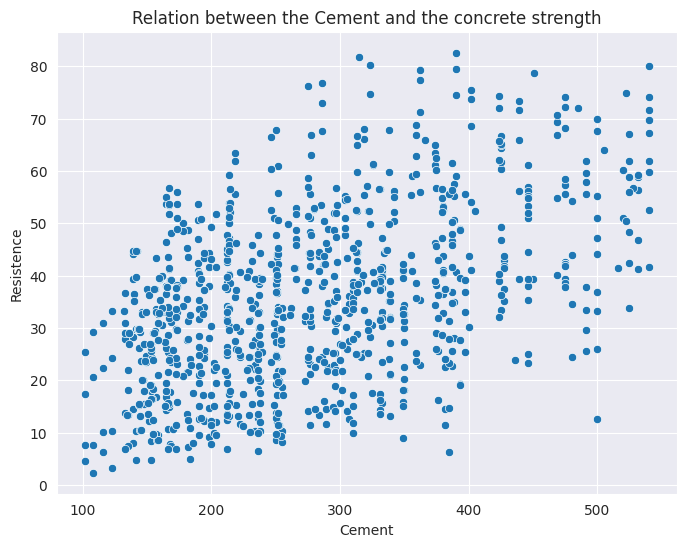

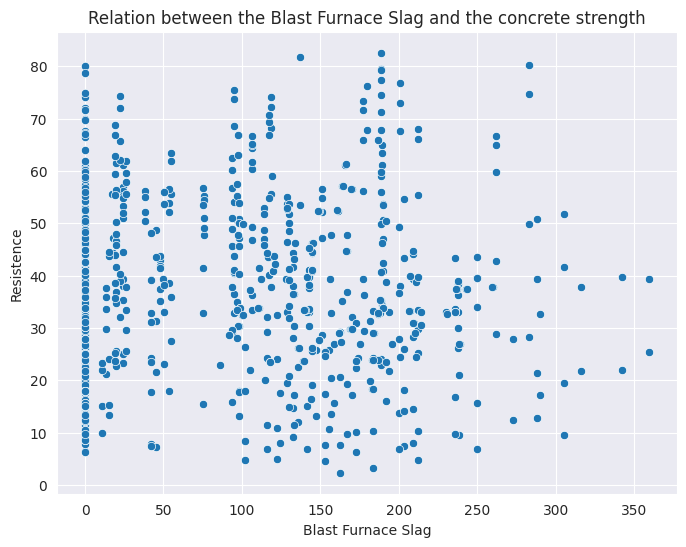

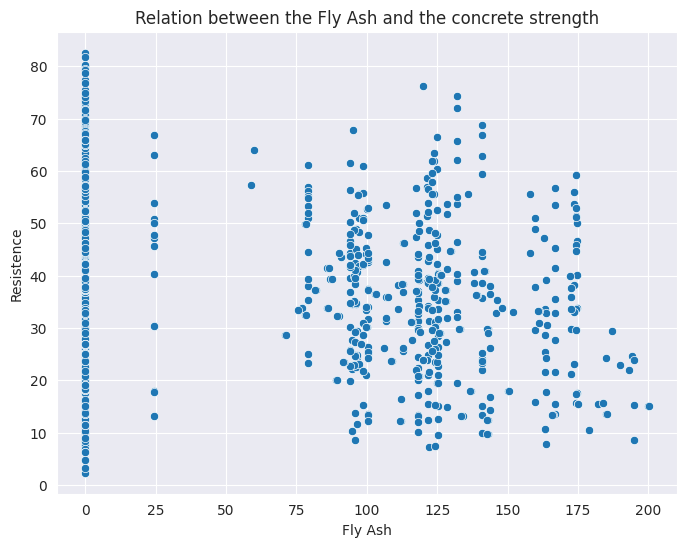

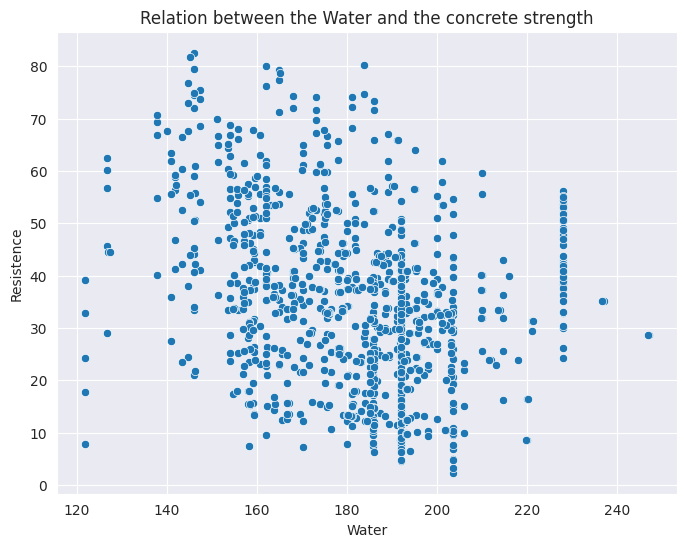

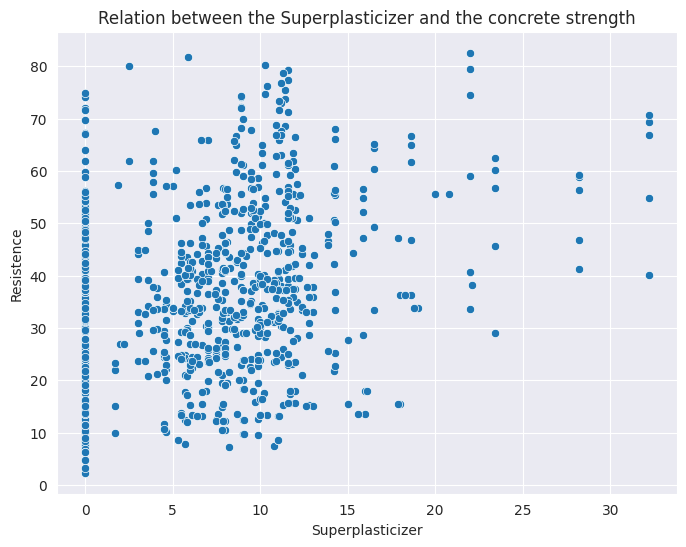

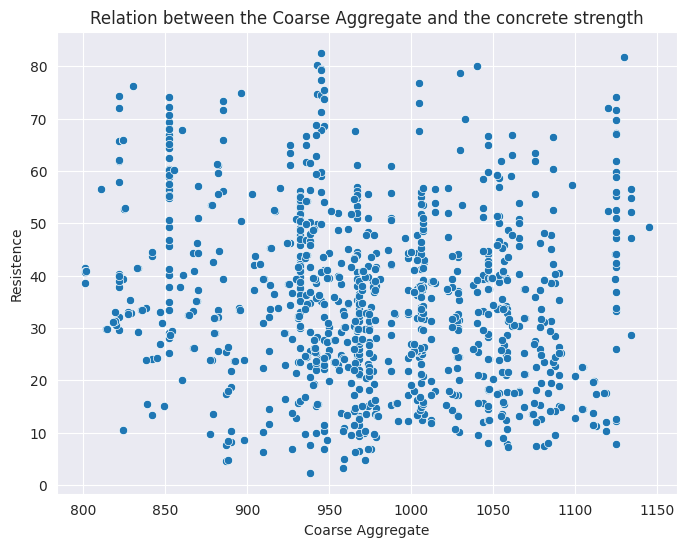

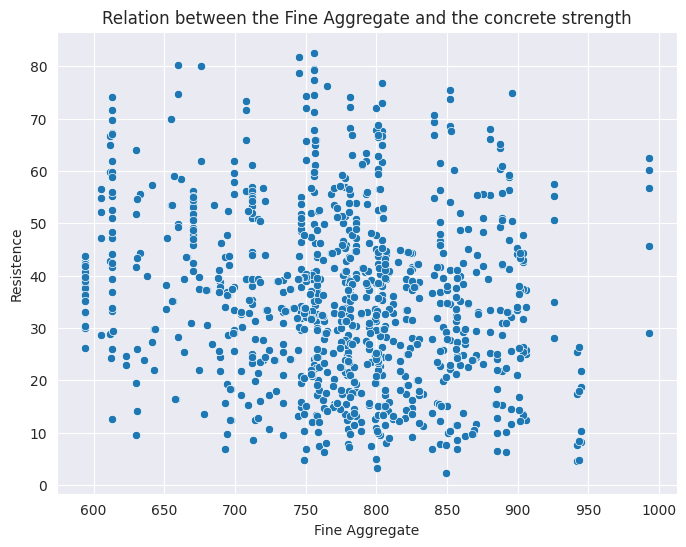

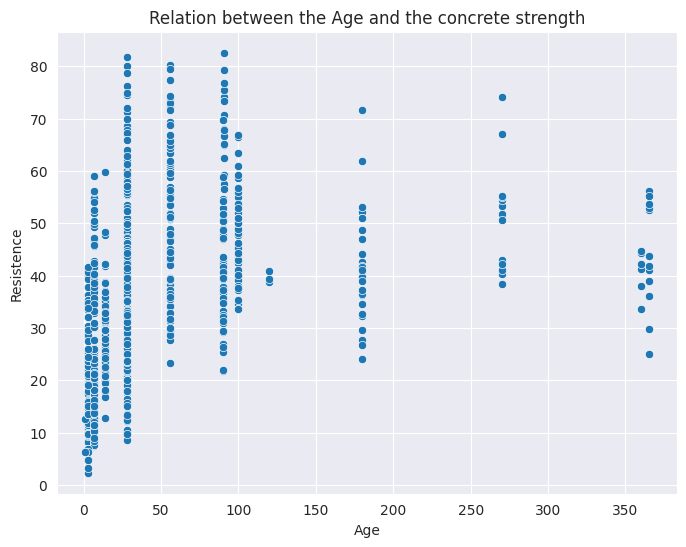

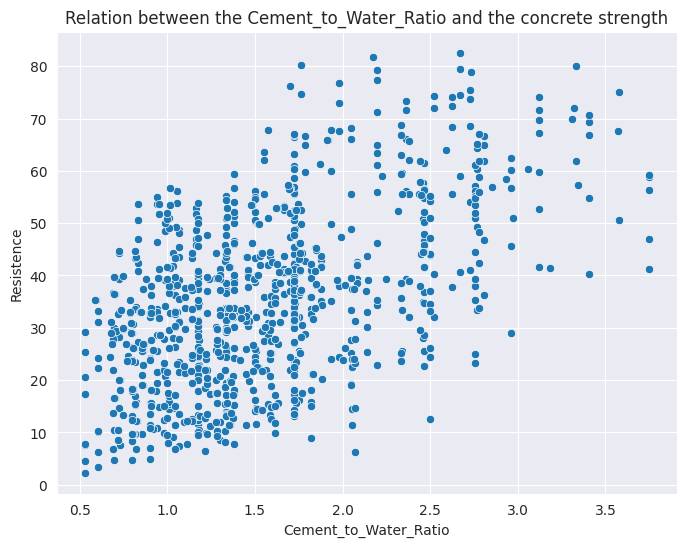

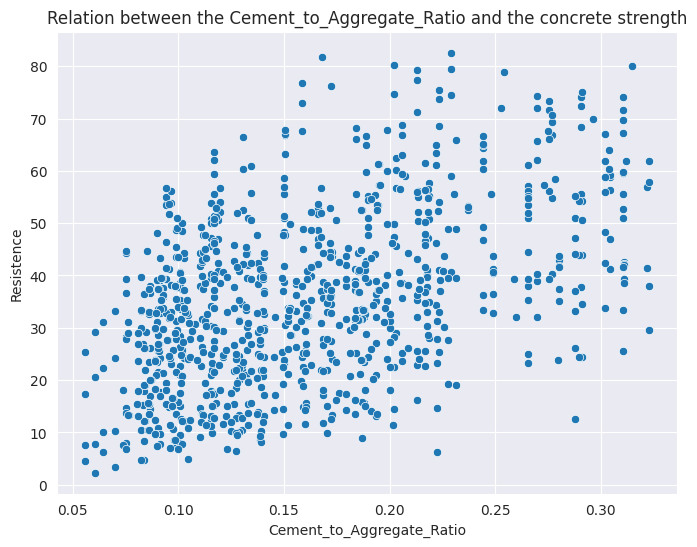

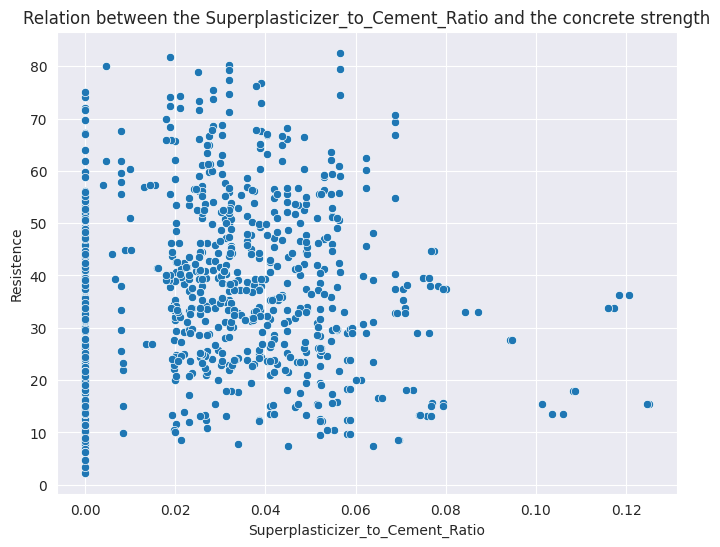

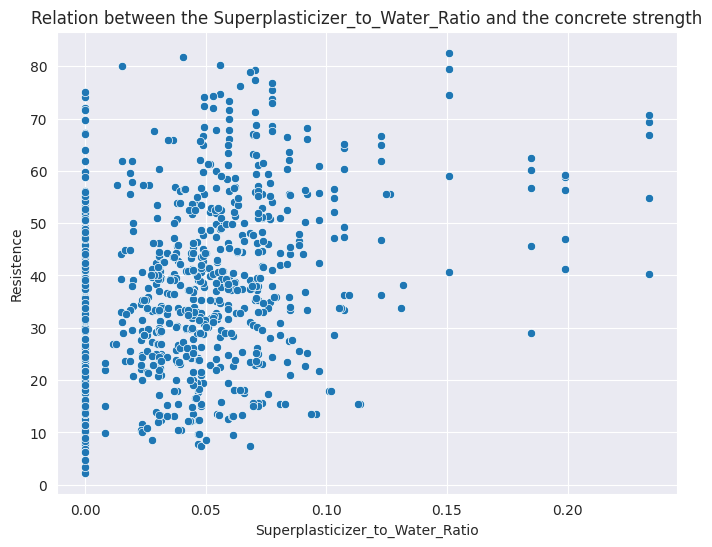

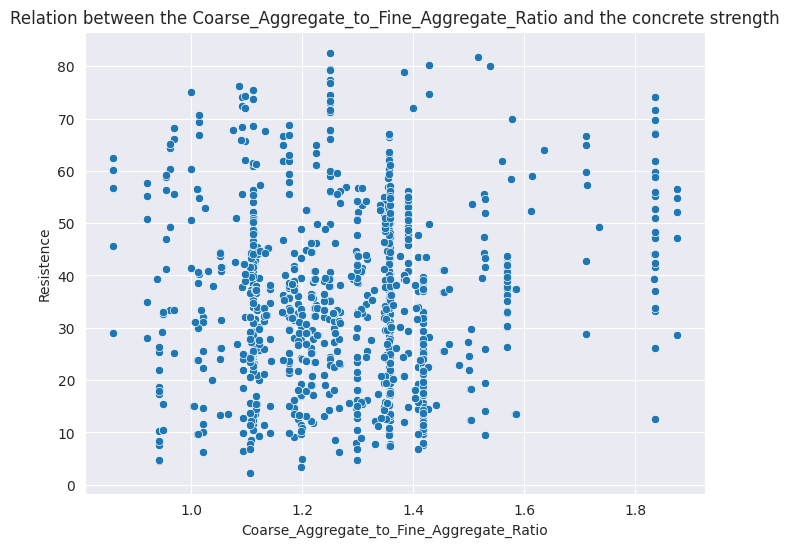

In [301]:
for column in df.columns:
    if column != 'Strength':  # Exclude the target column from plotting
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=df, x=column, y='Strength')
        plt.title(f'Relation between the {column} and the concrete strength')
        plt.xlabel(column)
        plt.ylabel('Resistence')
        plt.show()


### Machine Learning

Calculation the correlation between the variables

In [302]:
corr_matrix = df.corr()

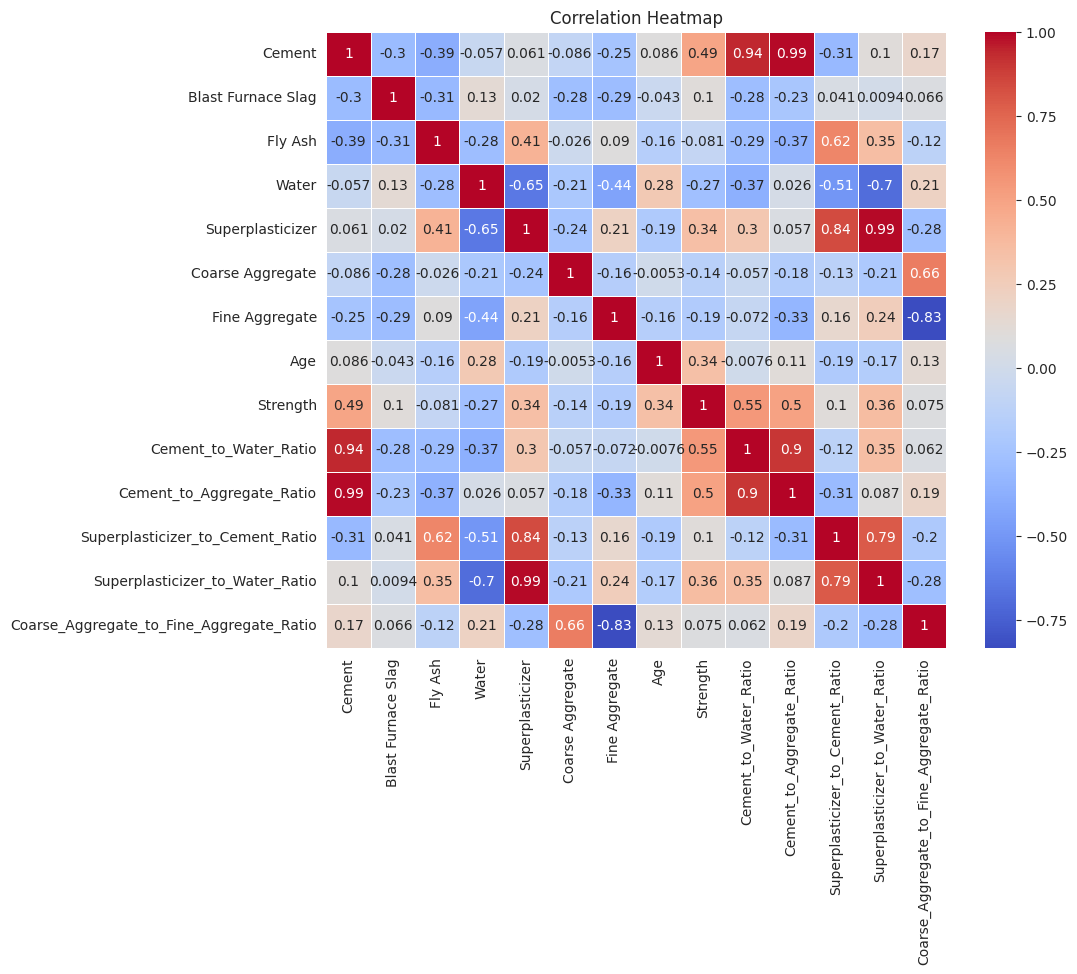

In [303]:
# Plotting the heat map

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


Dropping columns that are used in ratios or are not useful for the model.

In [304]:
df.columns.to_list()

['Cement',
 'Blast Furnace Slag',
 'Fly Ash',
 'Water',
 'Superplasticizer',
 'Coarse Aggregate',
 'Fine Aggregate',
 'Age',
 'Strength',
 'Cement_to_Water_Ratio',
 'Cement_to_Aggregate_Ratio',
 'Superplasticizer_to_Cement_Ratio',
 'Superplasticizer_to_Water_Ratio',
 'Coarse_Aggregate_to_Fine_Aggregate_Ratio']

In [305]:
drop_columns = ['Cement', 'Water', 'Superplasticizer_to_Water_Ratio', 'Superplasticizer_to_Cement_Ratio', 'Cement_to_Aggregate_Ratio','Coarse_Aggregate_to_Fine_Aggregate_Ratio']

df = df.drop(drop_columns, axis=1)

df.head()

,Blast Furnace Slag,Fly Ash,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength,Cement_to_Water_Ratio
0,0.0,0.0,2.5,1040.0,676.0,28,79.99,3.333333
1,0.0,0.0,2.5,1055.0,676.0,28,61.89,3.333333
2,142.5,0.0,0.0,932.0,594.0,270,40.27,1.458333
3,142.5,0.0,0.0,932.0,594.0,365,41.05,1.458333
4,132.4,0.0,0.0,978.4,825.5,360,44.30,1.034375


Creating the training, testing and validation datasets

In [306]:
y = df.pop('Strength')

X = df

In [307]:
# Split into training and temporary (test + validation) sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 2: Split the temporary set into test and validation sets
# X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Standard scaler

In [308]:
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

Creating a model for the Concrete Strength

In [309]:
# Define the models to be tested
models = {
    'Linear Regression': LinearRegression(),
    'Support Vector Machine Regressor': SVR(),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Random Forest Regressor': RandomForestRegressor()
}



Model: Linear Regression
Mean MSE: 120.2012 ± 31.7417
--------------------------------------------------


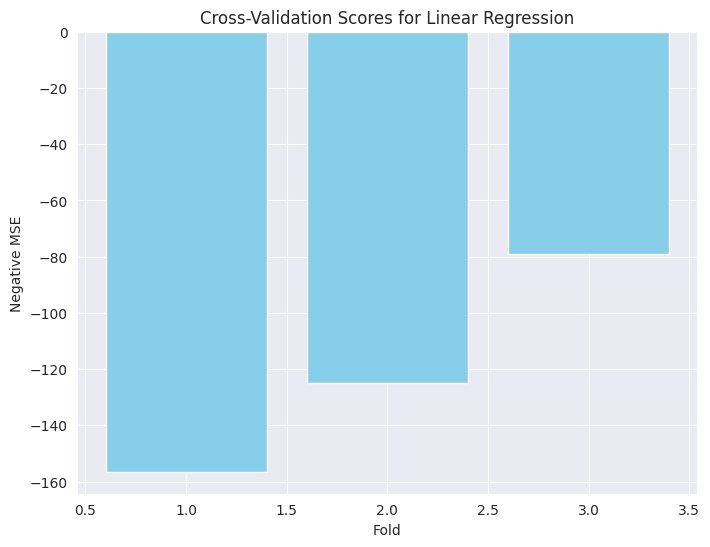

Model: Support Vector Machine Regressor
Mean MSE: 273.5646 ± 64.4518
--------------------------------------------------


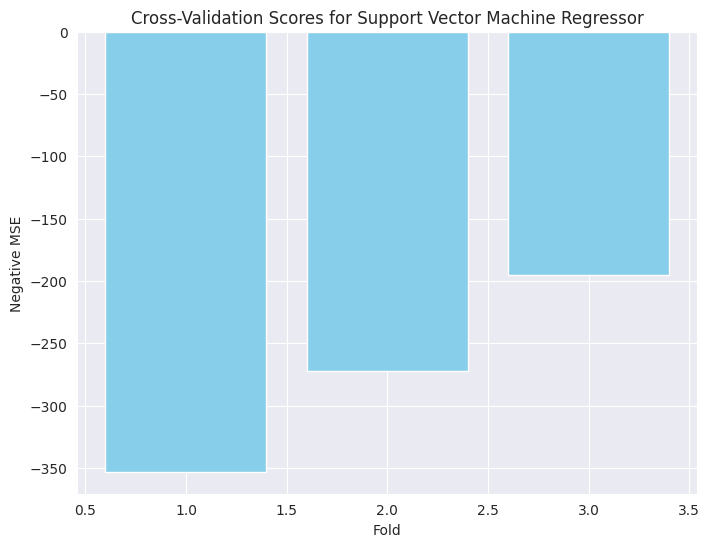

Model: K-Nearest Neighbors Regressor
Mean MSE: 280.3420 ± 40.6143
--------------------------------------------------


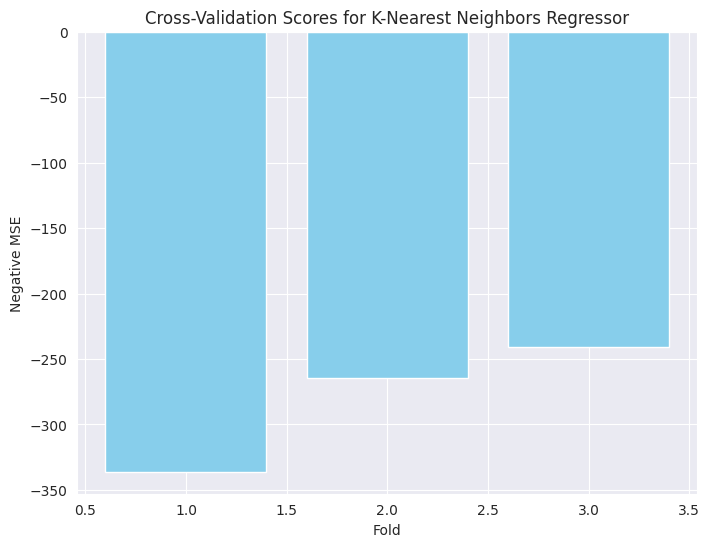

Model: Decision Tree Regressor
Mean MSE: 172.4111 ± 91.5878
--------------------------------------------------


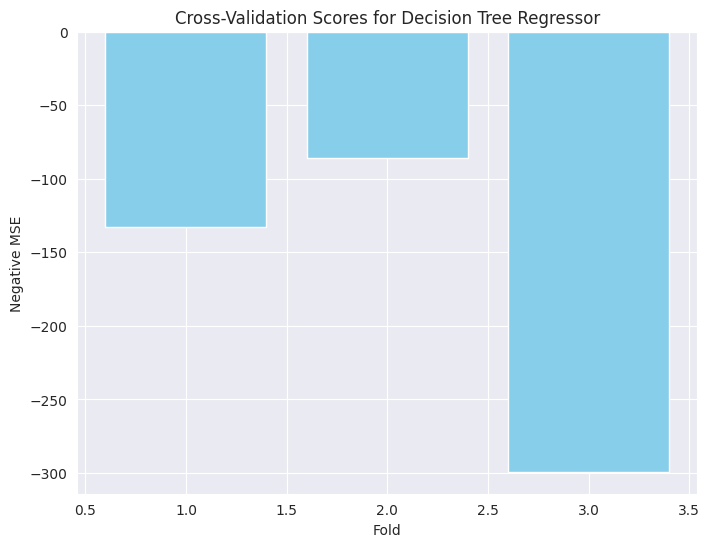

Model: Random Forest Regressor
Mean MSE: 107.0148 ± 48.2413
--------------------------------------------------


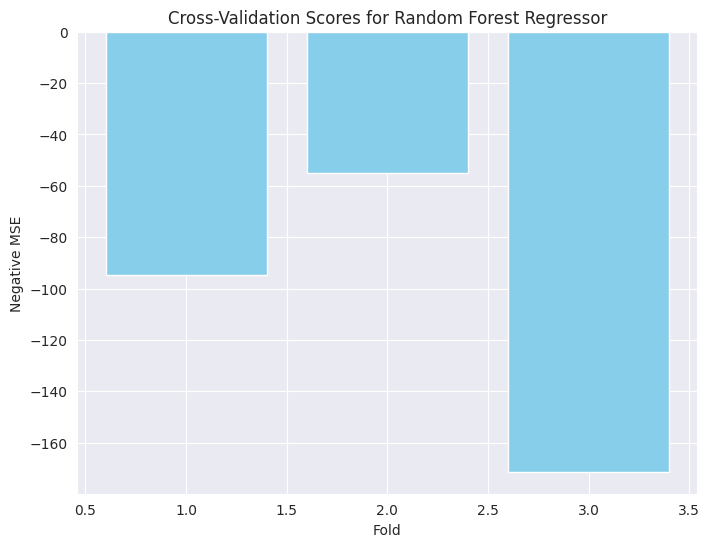

In [310]:
# Perform cross-validation and plot the results
for name, model in models.items():
    # Perform 5-fold cross-validation
    scores = cross_val_score(model, X, y, cv=3, scoring='neg_mean_squared_error')
    
    # Convert negative mean squared error to positive
    mse_scores = -scores
    
    # Calculate mean and standard deviation of the scores
    mean_mse = np.mean(mse_scores)
    std_mse = np.std(mse_scores)
    
    # Print results
    print(f"Model: {name}")
    print(f"Mean MSE: {mean_mse:.4f} ± {std_mse:.4f}")
    print("-" * 50)
    
    # Plot the cross-validation scores
    plt.figure(figsize=(8, 6))
    plt.bar(range(1, len(scores) + 1), scores, color='skyblue')
    plt.xlabel('Fold')
    plt.ylabel('Negative MSE')
    plt.title(f'Cross-Validation Scores for {name}')
    plt.show()
   


Hypertuning the paramenter of the Random Forest Model 

In [311]:
# Define the Random Forest model
rf_model = RandomForestRegressor()


In [312]:

# Define the hyperparameter distribution to sample from
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


In [313]:

# Perform Random Search with cross-validation
random_search = RandomizedSearchCV(
    rf_model,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=5,        # Number of folds in cross-validation
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1      # Use all available CPU cores
)


In [314]:

# Fit the Random Search model to the data
random_search.fit(X, y)


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 300]},
                   random_state=42, scoring='neg_mean_squared_error')

In [315]:

# Get the best parameters and the best score
best_params = random_search.best_params_
best_score = -random_search.best_score_


In [316]:

# Print the best parameters and the best score
print(f"Best Parameters: {best_params}")
print(f"Best Score (Negative MSE): {best_score:.4f}")

# Train the best model on the entire dataset
best_rf_model = random_search.best_estimator_
best_rf_model.fit(X, y)

# Make predictions on the test set
y_pred = best_rf_model.predict(X)

# Calculate mean squared error and R^2 score
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

# Print the final evaluation metrics
print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")


Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30, 'bootstrap': True}
Best Score (Negative MSE): 106.8954
Mean Squared Error: 3.4664
R^2 Score: 0.9869


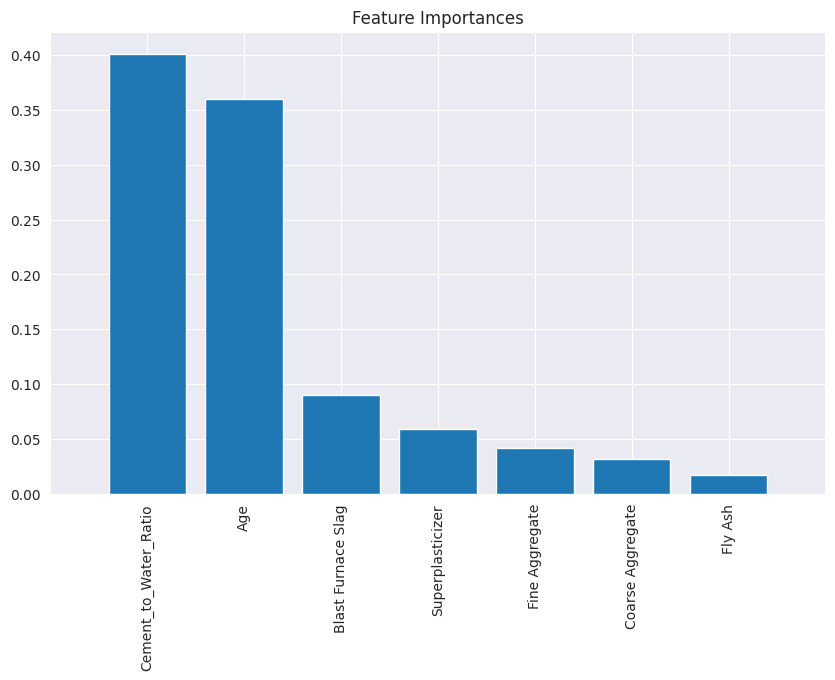

In [317]:

# Plot the feature importances
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()